In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from collections import Counter
from PIL import Image
import os

In [6]:
input_path = '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu'
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]
subject_path

['/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_02.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_03.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_04.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_05.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_06.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_07.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_08.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_09.mat',
 '/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_10.mat']

In [7]:
mat = scipy.io.loadmat(subject_path[0])
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

Size of image is (61, 496, 768) , Resolution of image is 496 x 768
Size of manual fluid is (61, 496, 768) , Resolution of manual fluid is 496 x 768


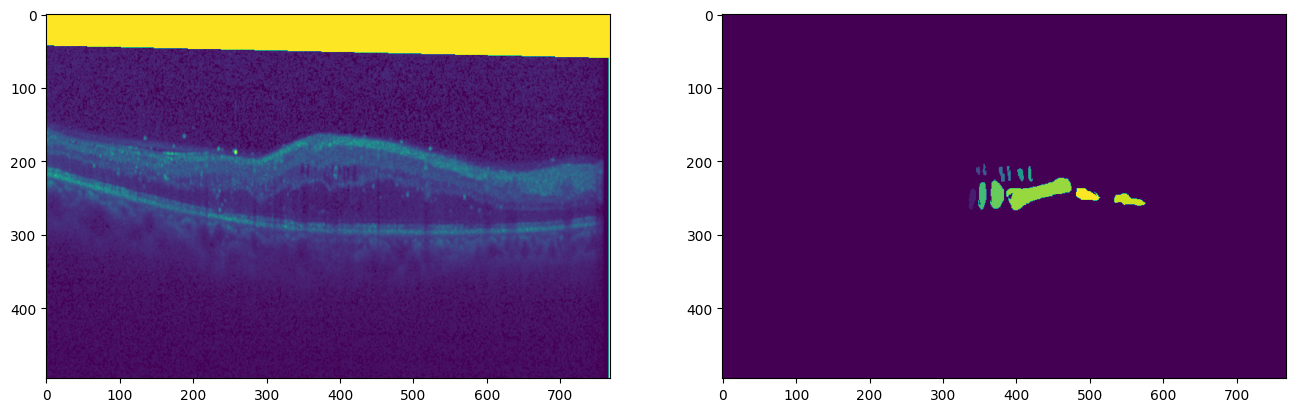

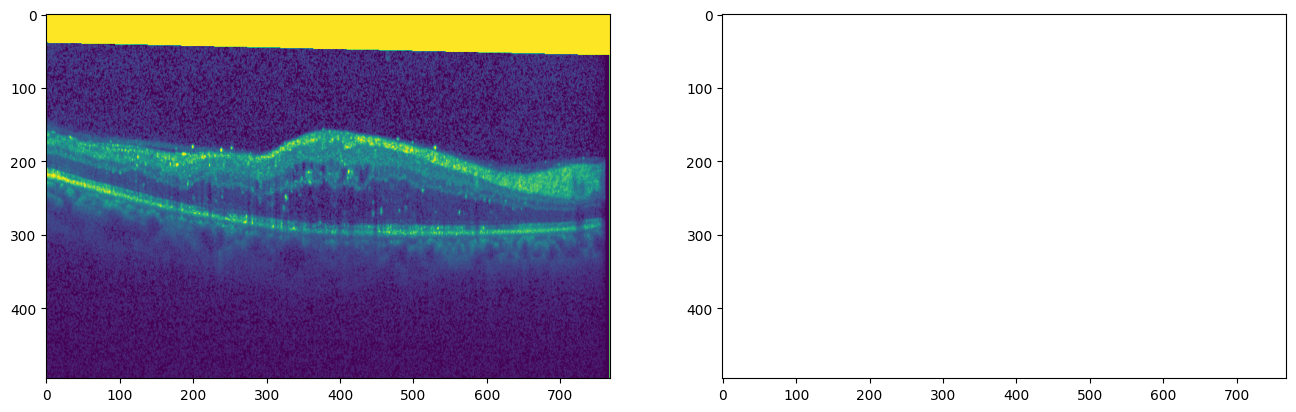

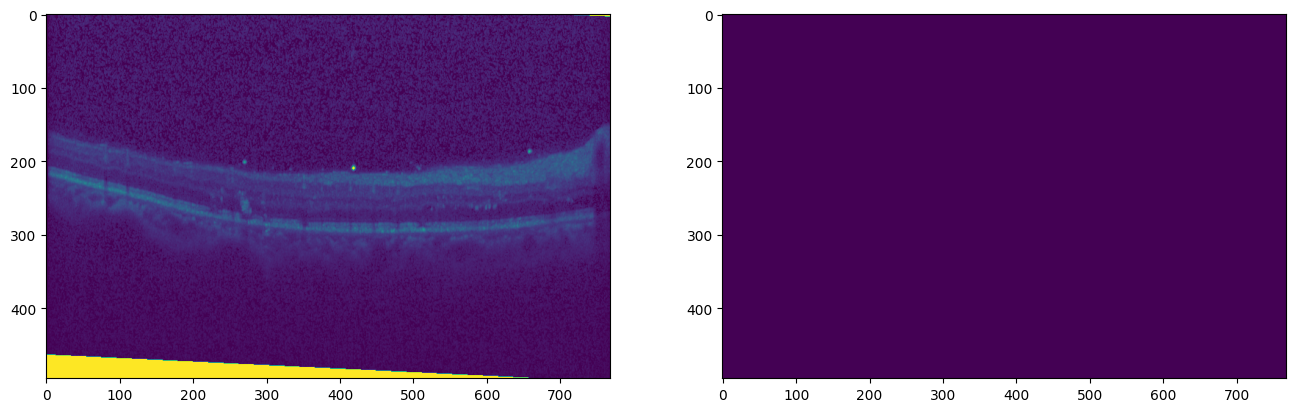

In [8]:
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

print(f"Size of image is {img_array.shape}", f", Resolution of image is {img_array.shape[1]} x {img_array.shape[2]}")
print(f"Size of manual fluid is {manual_fluid_array.shape}", f", Resolution of manual fluid is {manual_fluid_array.shape[1]} x {manual_fluid_array.shape[2]}")

# visualize img_array and manual_fluid_array
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_array[20])
ax[1].imshow(manual_fluid_array[20])

# visualize img_array and manual_fluid_array
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_array[21])
ax[1].imshow(manual_fluid_array[21])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_array[45])
ax[1].imshow(manual_fluid_array[45])

In [17]:
def find_path_idx(paths):
    num_img = 0
    path_idx = []
    for path in paths:
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        manual_fluid_tensor_1 = mat['manualFluid1']

        img_array = np.transpose(img_tensor, (2, 0, 1))
        manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

        num_img += img_array.shape[0]

        for i in range(manual_fluid_array.shape[0]):
            if np.isnan(manual_fluid_array[i]).all():
                continue
            else:
                path_idx.append((path, i))
                # print(i, Counter(manual_fluid_array[i].flatten()))

    print(f"There are {num_img} images in the dataset.")
    print(f"There are {len(path_idx)} images with fluid in the dataset.")
    return path_idx


In [18]:
path_idx = find_path_idx(subject_path)
path_idx

There are 610 images in the dataset.
There are 110 images with fluid in the dataset.


[('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 10),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 15),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 20),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 25),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 28),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 30),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 32),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 35),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 40),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 45),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_01.mat', 50),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_02.mat', 10),
 ('/workspaces/YJ_661_final_project/data/2015_BOE_Chiu/Subject_02.mat', 15),

**NOTE**: 
1. NO reshape when creating x and y, output image size is 496*768
2. Add thresh, it will become a binary segmentation problem

In [19]:
# create a full dataset of images and manual fluid
def thresh(x):
    if x <= 0.3:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[float])

def create_dataset(paths, path_idx):
    x = []
    y = []

    for path in paths:
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        manual_fluid_tensor_1 = mat['manualFluid1']

        img_array = np.transpose(img_tensor, (2, 0, 1)) / 255 
        # img_array = resize(img_array, (img_array.shape[0], width, height))
        manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))
        manual_fluid_array = thresh(manual_fluid_array)
        # manual_fluid_array = resize(manual_fluid_array, (manual_fluid_array.shape[0], width, height))

        for i in range(manual_fluid_array.shape[0]):
            if (path, i) in path_idx:
                x += [np.expand_dims(img_array[i], 0)]
                y += [np.expand_dims(manual_fluid_array[i], 0)]
    return np.array(x), np.array(y)


In [20]:
x, y = create_dataset(subject_path, path_idx)
print(f"Size of x is {x.shape}", f"Size of y is {y.shape}")

/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in thresh (vectorized)
  outputs = ufunc(*inputs)


Size of x is (110, 1, 496, 768) Size of y is (110, 1, 496, 768)


In [21]:
# save x and y
def save_dataset(x, y, output_path):
    np.save(os.path.join(output_path, 'x.npy'), x)
    np.save(os.path.join(output_path, 'y.npy'), y)
    print("Save x and y successfully!")
    pass

output_path = '/workspaces/YJ_661_final_project/data/'
save_dataset(x, y, output_path)

Save x and y successfully!


x.npy, y.npy too large to push to github, saved to https://drive.google.com/drive/folders/1Ezs9MNBTFzKjBQck5Ao6UaToiMaaYO-8?usp=drive_link if needed.

In [34]:
def save_arr_to_img(arr, output_path, flag=True):
    for i in range(arr.shape[0]):
        if flag == True:
            arr_ = (arr[i, 0, :, :] * 255).astype(np.uint8)
        arr_ = (arr[i, 0, :, :]).astype(np.uint8)
        img = Image.fromarray(arr_, 'L')
        # img = img.convert('RGB')
        img.save(os.path.join(output_path, f'img_{i}.png'))
    print("Save images successfully!")
    pass

# output_path = '/workspaces/YJ_661_final_project/data/img_for_inference'
# save_arr_to_img(x, output_path)

In [35]:
output_path = '/workspaces/YJ_661_final_project/data/annotation_2d_binary'
save_arr_to_img(y, output_path, flag=False)

Save images successfully!
